
# Covid-19 Prediction from Patients Chest X-ray's Image using CNN Deep Transfer 
Learning



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##**Covid-19 Prediction from Patients Chest X-ray's Image using CNN Deep Transfer Learning**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import os
from glob import glob
import json
import os.path as osp
import sys
import math
from PIL import Image
import PIL.ImageDraw
import io
import shutil

Using TensorFlow backend.


In [3]:
keras.__version__

'2.3.1'

In [4]:
tf.__version__

'2.2.0'

In [0]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc,roc_curve,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd "/content/drive/My Drive/COVID19/"

/content/drive/My Drive/COVID19


In [0]:
#Define hyperparameter variable which will be used later
img_size=150
nb_classes = 2  # number of classes
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 20  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

#**1.Data Collection**

In [0]:
#In the GenerateDataSet method collect all image file path from COVID-19 and NORMAL folder and return as dataframe.
#In this dataframe, ImageName has file path and "Class" has label value 0 for NORMAL and 1 for COVID-19.
#Note : PNEUMONIA folder is not in use here
def GenerateDataSet(rootFolder):
    rows_list = []
    listOfFiles = os.listdir(rootFolder)
    for l in listOfFiles:
      if l=="PNEUMONIA":
        continue
      subFolder = rootFolder + "/" + l
      label=0
      if l == "COVID-19":
        label=1
      
      for label_file in glob(osp.join(subFolder, '*.*')):
        rows_list.append({'ImageName':label_file,'Class':label})
      
    return pd.DataFrame(rows_list)

In [0]:
#Get Dataset
df=GenerateDataSet("./Dataset")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageName  463 non-null    object
 1   Class      463 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.4+ KB


In [12]:
df.head()

,ImageName,Class
0,./Dataset/NORMAL/IM-0007-0001.jpeg,0
1,./Dataset/NORMAL/IM-0009-0001.jpeg,0
2,./Dataset/NORMAL/IM-0010-0001.jpeg,0
3,./Dataset/NORMAL/IM-0011-0001-0001.jpeg,0
4,./Dataset/NORMAL/IM-0011-0001-0002.jpeg,0


#**2.Exploratory Data Analysis**

In [13]:
df["Class"].value_counts()

1    233
0    230
Name: Class, dtype: int64

In [14]:
print("Total COVID-19 Class Count : ",df["Class"].value_counts()[1])
print("Total NORMAL Class Count : ",df["Class"].value_counts()[0])

Total COVID-19 Class Count :  233
Total NORMAL Class Count :  230


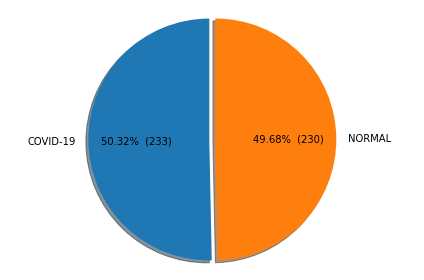

In [15]:
# Pie chart
labels = ['COVID-19', 'NORMAL']
sizes = [df["Class"].value_counts()[1], df["Class"].value_counts()[0]]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.05)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}%  ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [0]:
covid_df=df[df["Class"]==1]
normal_df=df[df["Class"]==0]

####**Sample picture from NORMAL patient X-ray Images**

In [17]:
# fig=plt.figure(figsize=(15, 15))

# columns = 5
# rows = 2
# for i in range(1, 6):
#     img = cv2.imread(normal_df.iloc[i].ImageName)
#     img = cv2.resize(img, (img_size, img_size))
#     fig.add_subplot(rows, columns, i)
#     plt.axis("off")
#     plt.imshow(img)
# plt.show()

NameError: ignored

<Figure size 1080x1080 with 0 Axes>

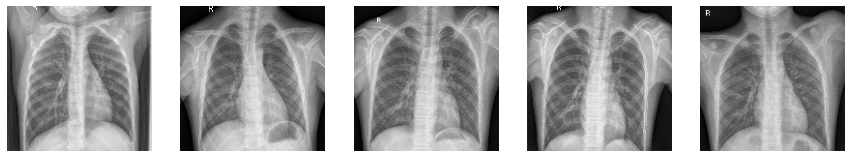

In [27]:
fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(normal_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

#####**Sample picture from COVID-19 positive patient X-ray Images**




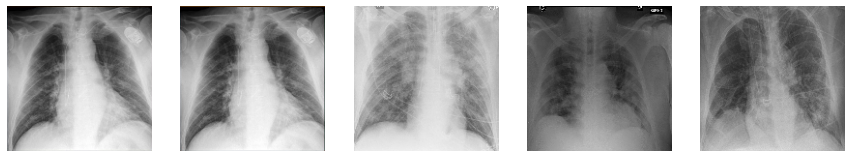

In [28]:
fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(covid_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [0]:
msk = np.random.rand(len(df)) < 0.80
train_df = df[msk]
test_df = df[~msk]

In [30]:
train_df.shape

(375, 2)

In [31]:
test_df.shape

(88, 2)

In [0]:
#This method used for pre-proceesing data from dataframe before modelling for Train and same will be used for Validate and Test data set.
#This method return image normalized data in numpy array format as X and corresponding label value in Y.
def imagePreProcess(data):
  X=[]
  Y=[]
  for i in data.itertuples():
    #Read image from physical file using Open CV
    img_arr = cv2.imread(i[1])
    #Resize image bytes to 150x150
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    X.append(resized_arr)
    Y.append(i[2])
  #Normalize the image data to 0-1 from 0-255 
  X=np.array(X)/255
  return X, np.array(Y)

In [0]:
X,y=imagePreProcess(train_df)

In [34]:
X.shape

(375, 150, 150, 3)

In [0]:
test_size = 0.20 # taking 80:20 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

In [0]:
X_test,y_test=imagePreProcess(test_df)

In [37]:
print("Total Data Count :",len(df["Class"]))
print("Total Train Data Count :",len(X_train))
print("Total Validation Data Count :",len(X_val))
print("Total Test Data Count :",len(X_test))

Total Data Count : 463
Total Train Data Count : 300
Total Validation Data Count : 75
Total Test Data Count : 88


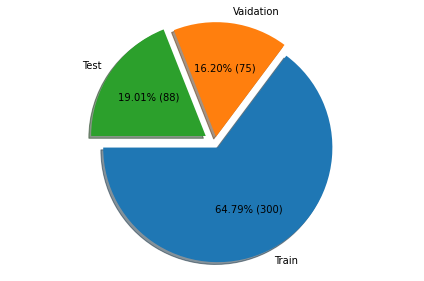

In [38]:
# Pie chart
labels = ['Train','Vaidation', 'Test']
sizes = [len(X_train), len(X_val),len(X_test)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.05, 0.05,0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}% ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=180)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

#**Deep Learning Image Binary Classification Model:**

#####Here we will be using Xception model base architecture with transfer learning technique to predict COVID-19

###**ResNet50 Model :**

In [39]:
base_ResNet50_Model=tf.keras.applications.ResNet50(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
# Top Model Block
x = base_ResNet50_Model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
# add your top layer block to your base model
resNet50_model = tf.keras.models.Model(base_ResNet50_Model.input, predictions)

In [0]:
resNet50_model.compile(optimizer='nadam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './resNet50_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
]

In [44]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
resNet50_history=resNet50_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=nb_epoch,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)







                                    

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.9000
Epoch 00001: val_loss improved from inf to 26.76293, saving model to ./resNet50_Best_model.h5
10/10 [==============================] - 92s 9s/step - loss: 0.3477 - accuracy: 0.9000 - val_loss: 26.7629 - val_accuracy: 0.4533
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9700
Epoch 00002: val_loss improved from 26.76293 to 4.53307, saving model to ./resNet50_Best_model.h5
10/10 [==============================] - 88s 9s/step - loss: 0.1641 - accuracy: 0.9700 - val_loss: 4.5331 - val_accuracy: 0.5467
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9767
Epoch 00003: val_loss improved from 4.53307 to 3.03838, saving model to ./resNet50_Best_model.h5
10/10 [==============================] - 92s 9s/step - loss: 0.0748 - accuracy: 0.9767 - val_loss: 3.0384 - val_accuracy: 0.5467
Epoch 4/20
10/10 [=======================

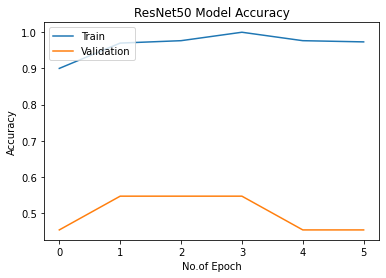

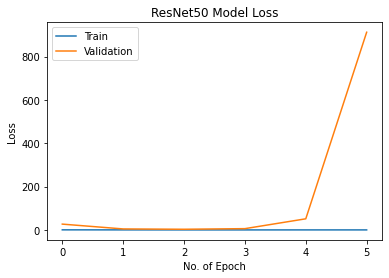

In [45]:
plt.plot(resNet50_history.history['accuracy'])
plt.plot(resNet50_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resNet50_history.history['loss'])
plt.plot(resNet50_history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


###**Xception Model**

In [46]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_xception_model = tf.keras.applications.Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
#Set pre-trained model layers to not trainable
#for layer in base_xception_model.layers:
   # layer.trainable = False

In [0]:
# Top Model Block
x = base_xception_model.output
#x=tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
# add your top layer block to your base model
xception_model = tf.keras.models.Model(base_xception_model.input, predictions)

In [0]:
xception_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [50]:
xception_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './xception_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [52]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
xception_history=xception_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8833
Epoch 00001: val_loss improved from inf to 10.45619, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 93s 9s/step - loss: 0.2853 - accuracy: 0.8833 - val_loss: 10.4562 - val_accuracy: 0.5733
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9767
Epoch 00002: val_loss improved from 10.45619 to 7.41796, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 95s 9s/step - loss: 0.0677 - accuracy: 0.9767 - val_loss: 7.4180 - val_accuracy: 0.7200
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9967
Epoch 00003: val_loss improved from 7.41796 to 6.08580, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 93s 9s/step - loss: 0.0294 - accuracy: 0.9967 - val_loss: 6.0858 - val_accuracy: 0.7733
Epoch 4/10
10/10 [=====

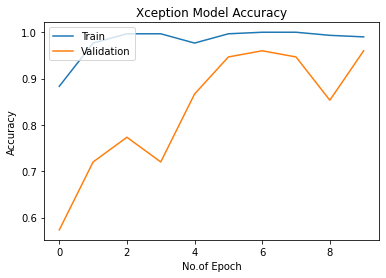

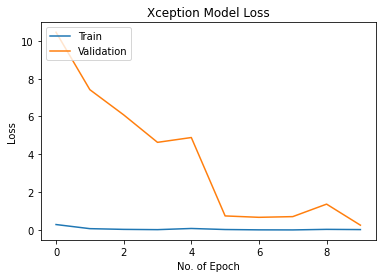

In [53]:
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('Xception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Xception Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##**InceptionV3**

In [54]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_InceptionV3_model = tf.keras.applications.InceptionV3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
# Top Model Block
x = base_InceptionV3_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# add your top layer block to your base model
InceptionV3_model = tf.keras.models.Model(base_InceptionV3_model.input, predictions)
InceptionV3_model.compile(optimizer='nadam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './InceptionV3_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [56]:
Inception_history=InceptionV3_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8933
Epoch 00001: val_loss improved from inf to 0.66166, saving model to ./InceptionV3_Final_Best_model.h5
10/10 [==============================] - 59s 6s/step - loss: 0.3271 - accuracy: 0.8933 - val_loss: 0.6617 - val_accuracy: 0.8400
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9833
Epoch 00002: val_loss did not improve from 0.66166
10/10 [==============================] - 55s 5s/step - loss: 0.0460 - accuracy: 0.9833 - val_loss: 6.1281 - val_accuracy: 0.6133
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 00003: val_loss did not improve from 0.66166
10/10 [==============================] - 54s 5s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.0676 - val_accuracy: 0.8133
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 00004: val_loss did not imp

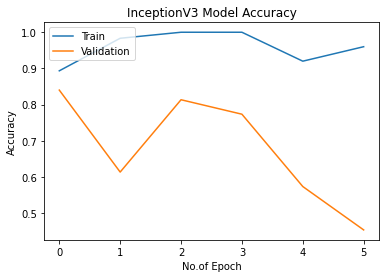

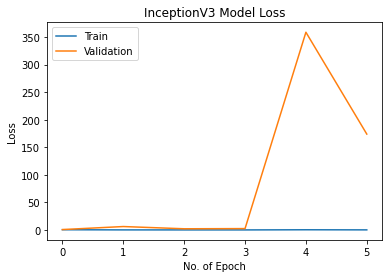

In [57]:
plt.plot(Inception_history.history['accuracy'])
plt.plot(Inception_history.history['val_accuracy'])
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Inception_history.history['loss'])
plt.plot(Inception_history.history['val_loss'])
plt.title('InceptionV3 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##**DenseNet201 Model :**

In [58]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_Densenet201_model = tf.keras.applications.DenseNet121(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
# Top Model Block
x = base_Densenet201_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# add your top layer block to your base model
DenseNet201_model = tf.keras.models.Model(base_Densenet201_model.input, predictions)
DenseNet201_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './DenseNet201_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [60]:
DenseNet201_history=DenseNet201_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.8933
Epoch 00001: val_loss improved from inf to 5.52594, saving model to ./DenseNet201_Final_Best_model.h5
10/10 [==============================] - 83s 8s/step - loss: 0.2296 - accuracy: 0.8933 - val_loss: 5.5259 - val_accuracy: 0.5600
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9700
Epoch 00002: val_loss did not improve from 5.52594
10/10 [==============================] - 80s 8s/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 88.7026 - val_accuracy: 0.5467
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9867
Epoch 00003: val_loss did not improve from 5.52594
10/10 [==============================] - 77s 8s/step - loss: 0.0195 - accuracy: 0.9867 - val_loss: 156.7581 - val_accuracy: 0.5467
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9833
Epoch 00004: val_loss did not 

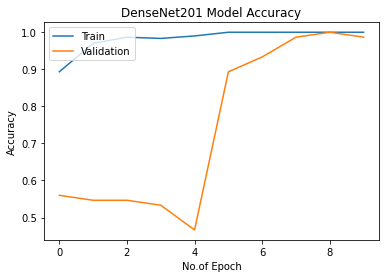

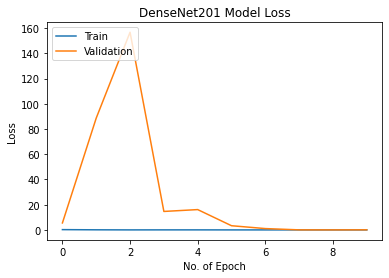

In [61]:
plt.plot(DenseNet201_history.history['accuracy'])
plt.plot(DenseNet201_history.history['val_accuracy'])
plt.title('DenseNet201 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(DenseNet201_history.history['loss'])
plt.plot(DenseNet201_history.history['val_loss'])
plt.title('DenseNet201 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##**Model Prediction Using Test Data**


In [0]:
def model_Prediction(model_Name,model_FilePath,x_Feature,true_Label):
  #Load trained best model file (.h5) from loacal folder
  model=tf.keras.models.load_model(model_FilePath)
  #Modelprediction
  predictions = model.predict(x_Feature)
  predicted_label=[]
  #
  for i in predictions:
    if(i[0] > 0.5):
      predicted_label.append(1)
    else:
      predicted_label.append(0)
  
  predicted_label=np.array(predicted_label)
  #Calculate Accuracy
  accuracy=float(format(accuracy_score(true_Label,predicted_label),'.2f'))
  #Calculate Recall
  recall=float(format(recall_score(true_Label,predicted_label),'.2f'))
  #Calcuate Precision
  precision=float(format(precision_score(true_Label,predicted_label),'.2f'))
  #Calculate F1-Score
  f1score=float(format(f1_score(true_Label,predicted_label),'.2f'))
  #Get Confusion matrix between true lable and predicted label
  CM = confusion_matrix(true_Label, predicted_label)
  result={'ModelName':model_Name,'Accuracy':accuracy,'Recall':recall,'Precision':precision,'F1_Score':f1score}
  #Retrun result metrics report and Confusion Matrix
  return result,CM

In [0]:
#Predict test data with Xception Model
xception_Result,xceptionModel_CM=model_Prediction("Xception",'./xception_Final_Best_model.h5',X_test,y_test)

In [0]:
#Predict test data with InceptionV3 Model
InceptionV3_Result,InceptionV3_CM=model_Prediction("InceptionV3",'./InceptionV3_Final_Best_model.h5',X_test,y_test)

In [0]:
#Predict test data with ResNet 50 Model
resNet50_Result,resNet50_CM=model_Prediction("ResNet50",'./resNet50_Best_model.h5',X_test,y_test)

In [0]:
#Predict test data with DenseNet 201 Model
denseNet201_Result,denseNet201_CM=model_Prediction("DenseNet201",'./DenseNet201_Final_Best_model.h5',X_test,y_test)

In [0]:
result=[]
result.append(xception_Result)
result.append(InceptionV3_Result)
result.append(denseNet201_Result)
result.append(resNet50_Result)

result=pd.DataFrame(result)

In [68]:
result

,ModelName,Accuracy,Recall,Precision,F1_Score
0,Xception,0.93,0.87,1.00,0.93
1,InceptionV3,0.90,0.80,1.00,0.89
2,DenseNet201,0.97,0.98,0.96,0.97
3,ResNet50,0.51,1.00,0.51,0.68


##**Xception Model - Test Data Confusion Matrix**

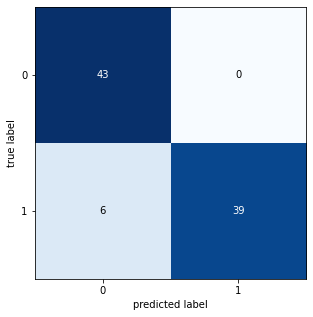

In [69]:
fig, ax = plot_confusion_matrix(conf_mat=xceptionModel_CM ,  figsize=(5, 5))
plt.show()


##**InceptionV3 Model - Test Data Confusion Matrix**

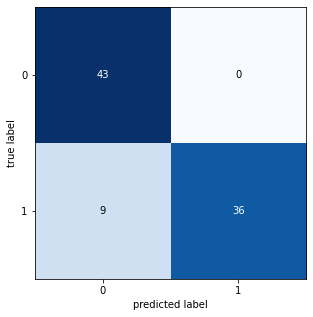

In [70]:
fig, ax = plot_confusion_matrix(conf_mat=InceptionV3_CM ,  figsize=(5, 5))
plt.show()
